## Census Income
https://www.kaggle.com/code/yashhvyass/adult-census-income-logistic-reg-explained-86-2

In [1]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import xgboost as xgb

# Project path
ppath = sys.path[0]

In [2]:
def plot_importance(classifer, x_train, point_size = 25):
    '''plot feature importance'''
    values = sorted(zip(x_train.columns, classifer.feature_importances_), key = lambda x: x[1] * -1)
    imp = pd.DataFrame(values,columns = ["Name", "Score"])
    imp.sort_values(by = 'Score',inplace = True)
    sns.set(font_scale = 2)
    sns.scatterplot(x = 'Score',y='Name', linewidth = 0,
                data = imp,s = point_size, color='red').set(
    xlabel='importance', 
    ylabel='features')

### No binning 

In [176]:
data = pd.read_csv(os.path.join(ppath, 'data', 'census+income', 'adult.data'), header=None)
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
data['income.bool'] = data['income'].apply(lambda x: 1 if x == ' >50K' else 0)
data[data == ' ?'] = np.nan
data.dropna(inplace=True)

y = data['income.bool']
X = data.drop(['income', 'income.bool', 'education.num', 'fnlwgt'], axis = 1)
category_var = [col for col in X.columns if X[col].dtypes == object]
numeric_var = [col for col in X.columns if X[col].dtypes != object]

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2) 

import category_encoders as ce
one_hot = ce.OneHotEncoder(cols = category_var, handle_unknown = 'ignore')

# Creating dataframe for categorical variables which converted to one hot encoded variables.
X_train_one_hot = pd.DataFrame(one_hot.fit_transform(X_train))
X_test_one_hot = pd.DataFrame(one_hot.transform(X_test))


X_train_one_hot.index = X_train.index
X_test_one_hot.index = X_test.index

num_X_train = X_train[numeric_var]
num_X_test = X_test[numeric_var]

# Joining numerical and one hot encoded variables to create our final X_train and X_test.
X_train_new = pd.concat([num_X_train, X_train_one_hot], axis = 1)
X_test_new = pd.concat([num_X_test, X_test_one_hot], axis = 1)


# X_train_new = pd.concat([num_X_train])
# X_test_new = pd.concat([num_X_test])

# Scaling our records into standard range of 0 and 1.
scaler = StandardScaler()

X_train_new = scaler.fit_transform(X_train_new)
X_test_new = scaler.transform(X_test_new)

model = xgb.XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02,    
                      seed=42)

model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.8664
      0    1
0  4255  228
1   578  972


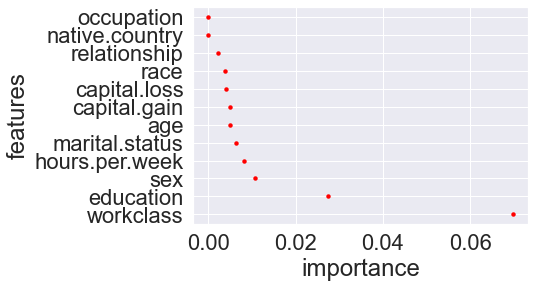

In [185]:
plot_importance(model, X_train, 20) 

### Some binning

In [15]:
data = pd.read_csv(os.path.join(ppath, 'data', 'census+income', 'adult.data'), header=None)
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'income']
data['income.bool'] = data['income'].map({' <=50K': 0, ' >50K': 1})
data = data.drop(['fnlwgt'], axis = 1)

In [16]:
category_var = [col for col in data.columns if data[col].dtypes == object]
for var in category_var:
    print(var)
    print(data[var].unique())
    print("--------------------")

workclass
[' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' ?' ' Self-emp-inc' ' Without-pay' ' Never-worked']
--------------------
education
[' Bachelors' ' HS-grad' ' 11th' ' Masters' ' 9th' ' Some-college'
 ' Assoc-acdm' ' Assoc-voc' ' 7th-8th' ' Doctorate' ' Prof-school'
 ' 5th-6th' ' 10th' ' 1st-4th' ' Preschool' ' 12th']
--------------------
marital.status
[' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
--------------------
occupation
[' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' ?'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
--------------------
relationship
[' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
--------------------
race
[' White' ' Black' ' Asian-Pac-Islander' ' Amer-Indian

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'education.num'}>],
       [<AxesSubplot:title={'center':'capital.gain'}>,
        <AxesSubplot:title={'center':'capital.loss'}>],
       [<AxesSubplot:title={'center':'hours.per.week'}>,
        <AxesSubplot:title={'center':'income.bool'}>]], dtype=object)

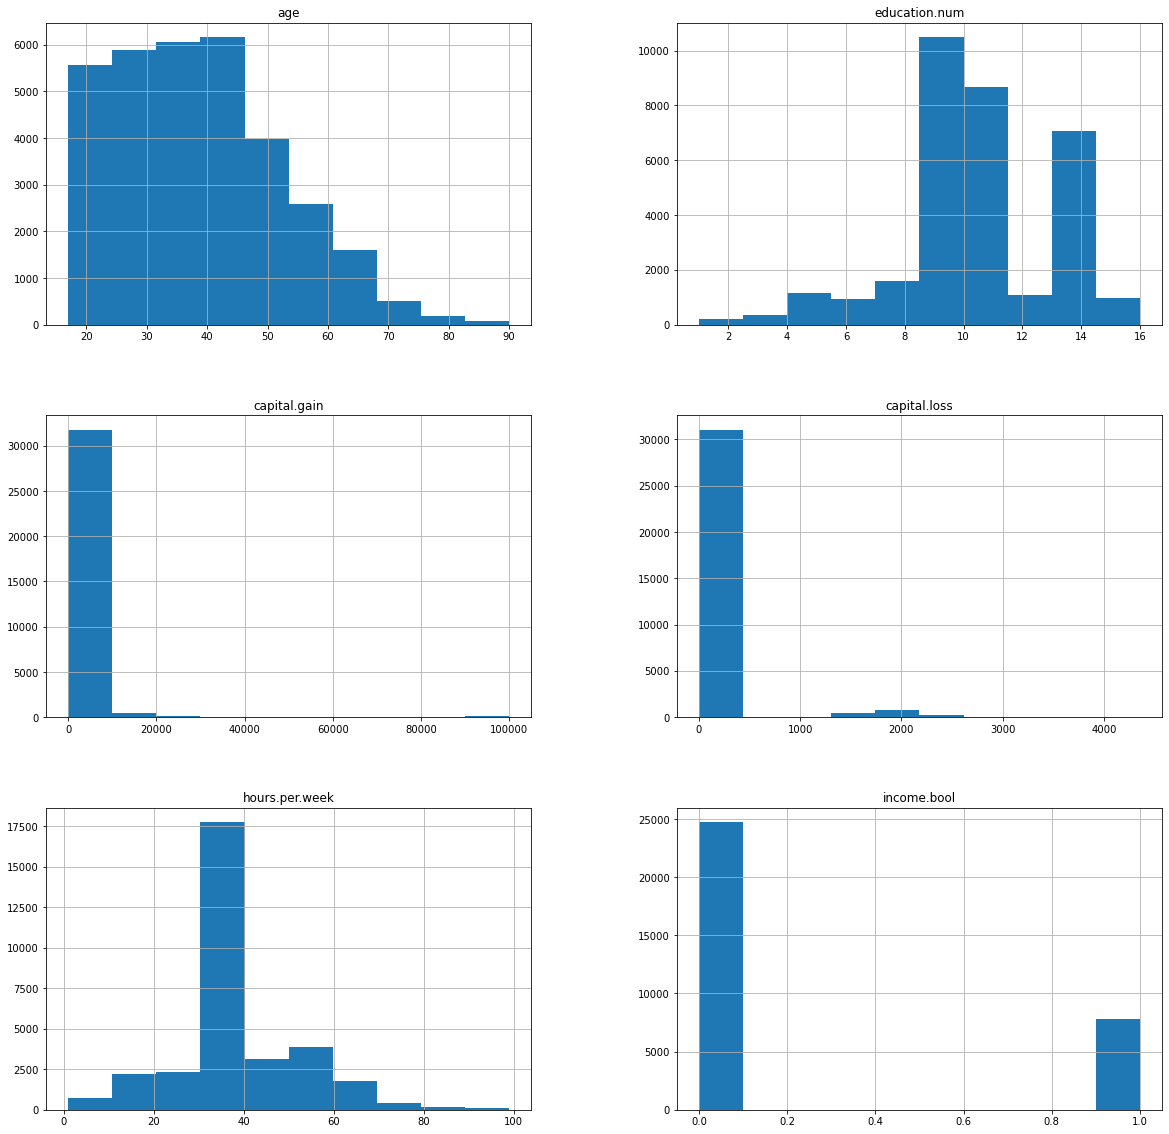

In [6]:
data.hist(figsize=(20, 20))

In [10]:
data[:5]

,age,workclass,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,income.bool
0,39,State-gov,4,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,4,13,Married,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,2,9,Prev-Married,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,1,7,Married,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,4,13,Married,Prof-specialty,Wife,Black,Female,0,0,40,Other,<=50K,0


#### Feature engineering

In [8]:
data[data == ' ?'] = np.nan
data.dropna(inplace=True)

# marital status
data['marital.status'] = data['marital.status'].str.strip()
data['marital.status'] = data['marital.status'].apply(lambda x: 'Prev-Married' if (x == 'Widowed' or x == 'Divorced' or x == 'Separated') else x)
data['marital.status'] = data['marital.status'].apply(lambda x: 'Married' if (x == 'Married-civ-spouse' or x == 'Married-spouse-absent' or x == 'Married-AF-spouse') else x)
# workclass
data.workclass = data.workclass.str.strip()
#data['workclass'] = data['workclass'].apply(lambda x: 'No income' if x == 'Never-worked' or x == 'Without-pay' else x)
# education
data.education = data.education.str.strip()
data['education'] = data['education'].apply(lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
                                              or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' 
                                              or x == 'Preschool' else x)
data['education'] = data['education'].apply(lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x)
education_map = {'School':1,
             'HS-grad':2,
             'Some-college':3,
             'Bachelors':4,
             'Prof-school':5,
             'Associate':6,
             'Masters':7,
             'Doctorate':8}
data['education'] = data['education'].map(education_map)
# native country
data['native.country'] = data['native.country'].str.strip()
data['native.country'] = data['native.country'].apply(lambda x: 'Other' if x != 'United-States' else x)

In [9]:
data.education = data.education.str.strip()
data['education'] = data['education'].apply(lambda x: 'School' if x == '11th' or x == '7th-8th' or x == '10th' 
                                              or x == '5th-6th' or x == '9th' or x == '12th' or x == '1st-4th' 
                                              or x == 'Preschool' else x)
data['education'] = data['education'].apply(lambda x: 'Associate' if x == 'Assoc-acdm' or x == 'Assoc-voc' else x)
data[['education', 'income.bool']].groupby(['education'], as_index=False).mean().sort_values(by='income.bool', ascending=False)

AttributeError: Can only use .str accessor with string values!

In [173]:
data[['education', 'income.bool']].groupby(['education'], as_index=False).mean().sort_values(by='income.bool', ascending=False)

,education,income.bool
10,Doctorate,0.740920
14,Prof-school,0.734375
12,Masters,0.556587
9,Bachelors,0.414753
8,Assoc-voc,0.261216
7,Assoc-acdm,0.248360
15,Some-college,0.190235
11,HS-grad,0.159509
2,12th,0.076212
0,10th,0.066452


Age

In [ ]:
data.loc[(data['age'] > 0) & (data['age'] <= 10), 'age'] = 1 #Children and teenagers
data.loc[(data['age'] > 10) & (data['age'] <= 20), 'age'] = 2 #Young Adults
data.loc[(data['age'] > 20) & (data['age'] <= 30), 'age'] = 3 #Middle aged
data.loc[(data['age'] > 30) & (data['age'] <= 40), 'age'] = 4 #Older Adults
data.loc[(data['age'] > 40) & (data['age'] <= 50), 'age'] = 4 #Older Adults
data.loc[data['age'] > 50, 'age'] = 5 #Senior Citizens

In [154]:
data.loc[(data['age'] > 0) & (data['age'] <= 20), 'age'] = 1 #Children and teenagers
data.loc[(data['age'] > 20) & (data['age'] <= 40), 'age'] = 2 #Adults
data.loc[(data['age'] > 40) & (data['age'] <= 70), 'age'] = 3 #Older Adults
data.loc[data['age'] > 70, 'age'] = 4 #Seniors

In [165]:
data.loc[(data['age'] > 0) & (data['age'] <= 18), 'age'] = 1 #Children and teenagers
data.loc[(data['age'] > 18) & (data['age'] <= 35), 'age'] = 2 #Young Adults
data.loc[(data['age'] > 35) & (data['age'] <= 50), 'age'] = 3 #Middle aged
data.loc[(data['age'] > 50) & (data['age'] <= 65), 'age'] = 4 #Older Adults
data.loc[data['age'] > 65, 'age'] = 5 #Senior Citizens

In [113]:
data[['age', 'income.bool']].groupby(['age'], as_index=False).mean().sort_values(by='income.bool', ascending=False)

,age,income
1,2,0.326405
2,3,0.141414
0,1,0.064510


In [90]:
data.loc[(data['age'] > 0) & (data['age'] <= 25), 'age'] = 1 #Generation Z
data.loc[(data['age'] > 25) & (data['age'] <= 40), 'age'] = 2 #Millenials
data.loc[(data['age'] > 40) & (data['age'] <= 55), 'age'] = 3 #Generation X
data.loc[(data['age'] > 55) & (data['age'] <= 75), 'age'] = 4 #Baby Boomers
data.loc[data['age'] > 75, 'age'] = 5 #Silent Generation

In [ ]:
data.loc[(data['age'] > 16) & (data['age'] <= 25), 'age'] = 1 #Young Adults
data.loc[(data['age'] > 25) & (data['age'] <= 32), 'age'] = 2 #Adults
data.loc[(data['age'] > 32) & (data['age'] <= 40), 'age'] = 3 #Middle aged Adults
data.loc[(data['age'] > 40) & (data['age'] <= 50), 'age'] = 4 #Older Adults
data.loc[data['age'] > 50, 'age'] = 5 #Senior Citizens

#### Modelling

In [13]:
y = data['income.bool']
X = data.drop(['income', 'income.bool', 'education.num'], axis = 1)
#X = X.drop('education', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, test_size = 0.2) 

category_var = [col for col in X.columns if X[col].dtypes == object]
numeric_var = [col for col in X.columns if X[col].dtypes != object]

import category_encoders as ce
one_hot = ce.OneHotEncoder(cols = category_var, handle_unknown = 'ignore')

# Creating dataframe for categorical variables which converted to one hot encoded variables.
X_train_one_hot = pd.DataFrame(one_hot.fit_transform(X_train))
X_test_one_hot = pd.DataFrame(one_hot.transform(X_test))

X_train_one_hot.index = X_train.index
X_test_one_hot.index = X_test.index

num_X_train = X_train[numeric_var]
num_X_test = X_test[numeric_var]

# Joining numerical and one hot encoded variables to create our final X_train and X_test.
X_train_new = pd.concat([num_X_train, X_train_one_hot], axis = 1)
X_test_new = pd.concat([num_X_test, X_test_one_hot], axis = 1)


# X_train_new = pd.concat([num_X_train])
# X_test_new = pd.concat([num_X_test])

# Scaling our records into standard range of 0 and 1.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_new = scaler.fit_transform(X_train_new)
X_test_new = scaler.transform(X_test_new)

In [167]:
import xgboost as xgb
model = xgb.XGBClassifier(max_depth=12,
                      n_estimators=250,
                      min_child_weight=8, 
                      subsample=0.8, 
                      learning_rate =0.02,    
                      seed=42)

model.fit(X_train_new, y_train)
y_predict = model.predict(X_test_new)
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

Accuracy Score is 0.86723
      0    1
0  4243  240
1   561  989


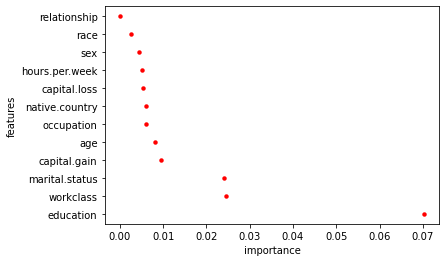

In [168]:
plot_importance(model, X_train, 20)